<a href="https://colab.research.google.com/github/lpoggetto/trabalho_final_DL_fiap/blob/main/DeepLearning_TrabalhoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Cleber Veiga Galvão - 356846
* Danildo André Amorim dos Santos - 355182
* Victor Marcio Hayee Falcão -  354955
* Lucas Ribeiro Del Poggetto - 355220

### Carregando os pacotes utilizados

In [1]:
# clonando repositorio com arquivos
!rm -rf *
!git clone https://github.com/lpoggetto/trabalho_final_DL_fiap.git

Cloning into 'trabalho_final_DL_fiap'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 49 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 2.56 MiB | 4.19 MiB/s, done.
Resolving deltas: 100% (18/18), done.


### Importando os pacotes utilizados

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model

### Importando os dados de treino para todas as ações

In [3]:
# lista de acoes
acoes_estudo = ['CSNA3', 'PETR4', 'VALE3', 'BBAS3']

# lista para salver os dataframes das acoes
frames = []

# iterando as acoes e importando os dados
for acao in acoes_estudo:
    # caminho do arquivo
    file_path = f"/content/trabalho_final_DL_fiap/{acao}.SA/treino.csv"
    # importando o dataset
    ds = pd.read_csv(file_path)
    frames.append(ds)

# concatenando todas em um unico arquivo
treino_ds = pd.concat(frames, ignore_index=True)

In [4]:
print('Shape do dataset: ',treino_ds.shape)

treino_ds.head()

Shape do dataset:  (19094, 20)


,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.409986,1.588954,-1,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777,1.658908
1,2,2000-01-26,1.398052,1.569864,-1,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777
2,3,2000-01-27,1.375888,1.550466,-1,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139
3,4,2000-01-28,1.363953,1.531815,-1,1.375888,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271
4,5,2000-01-31,1.329854,1.511619,-1,1.363953,1.375888,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336


In [5]:
#selecionar as features que interessam
colunasdelete = ['Unnamed: 0','Date','Close', 'Smoothed_Close']

treino_ds = treino_ds.drop(columns=colunasdelete, axis=1)

In [6]:
treino_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19094 entries, 0 to 19093
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Label               19094 non-null  int64  
 1   Past_1_Days_Close   19094 non-null  float64
 2   Past_2_Days_Close   19094 non-null  float64
 3   Past_3_Days_Close   19094 non-null  float64
 4   Past_4_Days_Close   19094 non-null  float64
 5   Past_5_Days_Close   19094 non-null  float64
 6   Past_6_Days_Close   19094 non-null  float64
 7   Past_7_Days_Close   19094 non-null  float64
 8   Past_8_Days_Close   19094 non-null  float64
 9   Past_9_Days_Close   19094 non-null  float64
 10  Past_10_Days_Close  19094 non-null  float64
 11  Past_11_Days_Close  19094 non-null  float64
 12  Past_12_Days_Close  19094 non-null  float64
 13  Past_13_Days_Close  19094 non-null  float64
 14  Past_14_Days_Close  19094 non-null  float64
 15  Past_15_Days_Close  19094 non-null  float64
dtypes: f

**Pré-processamento dos dados**

In [7]:
# Normalizando os dados
scaler = MinMaxScaler()
scaled_treino_ds = scaler.fit_transform(treino_ds.drop('Label', axis=1))

# Fazer o Reshape para usar LSTM
scaled_treino_ds = scaled_treino_ds.reshape((scaled_treino_ds.shape[0], 15, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 15, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,465 (126.82 KB)

 Trainable params: 32,465 (126.82 KB)

 Non-trainable params: 0 (0.00 B)

None


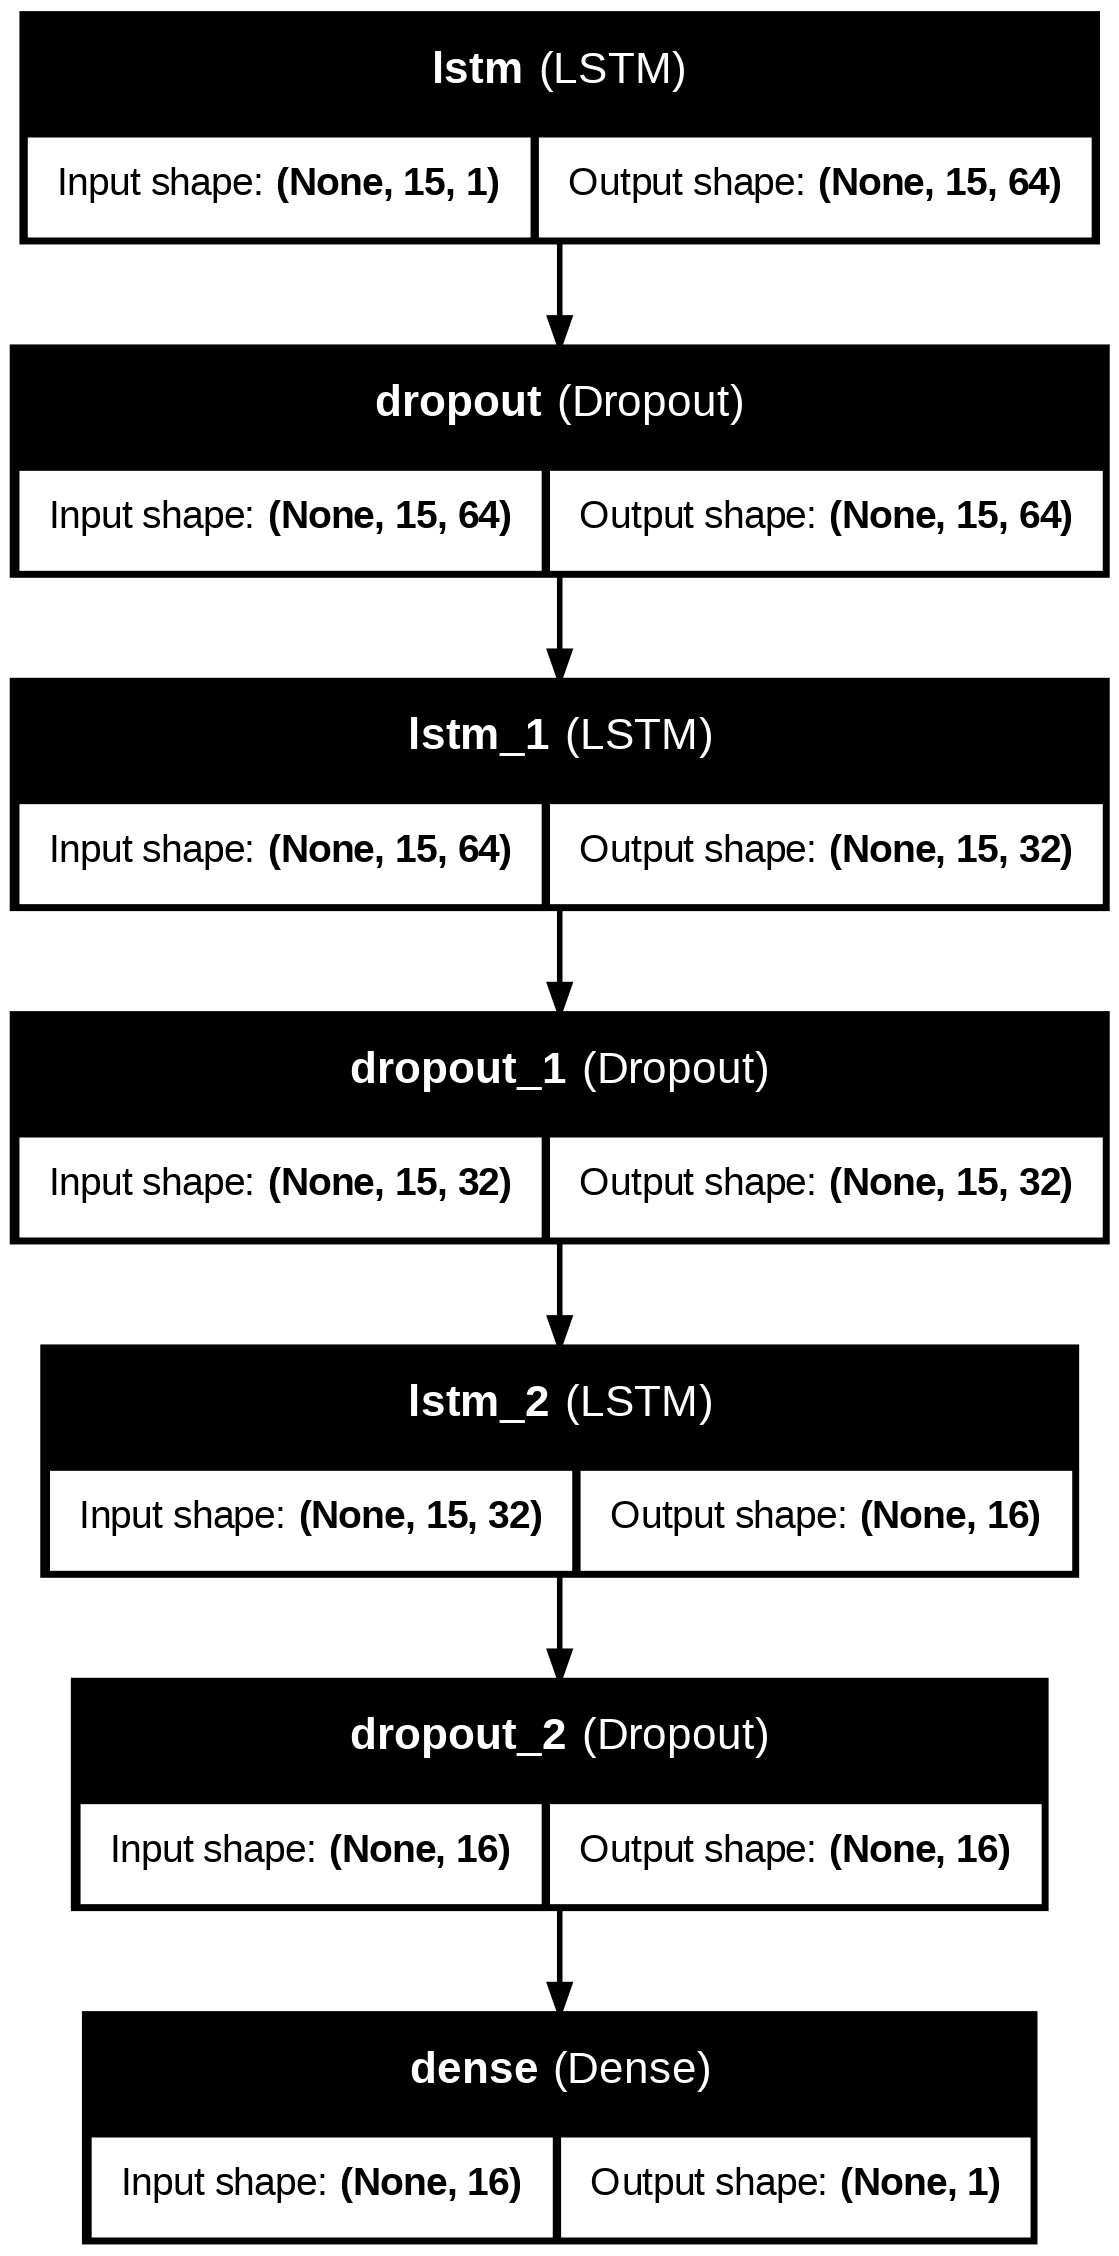

In [8]:
#Cria rede neural

model = Sequential()
model.add(LSTM(units=15, return_sequences=True, input_shape=(15, 1), seed=42))
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=False,seed=42))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

print(model.summary())

plot_model(model, to_file='/content/trabalho_final_DL_fiap/mlp-seq.png', show_shapes=True, show_layer_names=True)


In [ ]:
%%timeit
#Treinando o modelo
y_train = treino_ds['Label']
X_train = scaled_treino_ds

train_predictions = model.fit(X_train,
                              y_train,
                              epochs=30,
                              batch_size=300,
                              verbose=1)

Epoch 1/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.3073 - loss: 0.3749
Epoch 2/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.3136 - loss: 0.3603
Epoch 3/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.3153 - loss: 0.3658
Epoch 4/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.3011 - loss: 0.3678
Epoch 5/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.3134 - loss: 0.3515
Epoch 6/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.3119 - loss: 0.3568
Epoch 7/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.3104 - loss: 0.3668
Epoch 8/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.3167 - loss: 0.3582
Epoch 9/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.3025 - loss: 0.3709
Epoch 10/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.3135 - loss: 0.3528
Epoch 11/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.3109 - loss: 0.3617
Epoch 12/60
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - 

### Avaliando a performance do modelo para todas as ações


In [10]:
# definindo acoes do trabalho
acoes_estudo = ['BBAS3', 'CSNA3', 'PETR4', 'VALE3']

# criando dataframe vazio com os campos que serao avaliados para cada acao
layout = pd.DataFrame(
    {'Acao':[],
     'Accuracy':[],
     'Precision':[],
     'Recall':[]}
)

# criando dicionario vazio com os campos que serao avaliados
# as matrizes de confusao para cada acao
confusion_matrices = {}

for _acao in acoes_estudo:
    # ajustando o layout de escrita das acoes
    _acao = _acao.upper().strip()

    # iterando para cada acao na lista acoes_estudo e realizando a etapa de validacao
    teste_ds = pd.read_csv(f"/content/trabalho_final_DL_fiap/{_acao}.SA/" + "teste.csv")

    # ajustando o dataset para remover as colunas que nao sao utilizadas
    teste_ds = teste_ds.drop(columns=colunasdelete, axis=1)

    # aplicando scaler no dataset
    scaled_teste_ds = scaler.transform(teste_ds.drop('Label', axis=1))

    # aplicando reshape no dataset
    scaled_teste_ds = scaled_teste_ds.reshape((scaled_teste_ds.shape[0], 15, 1))

    # Separando os dados X e y
    X_test = scaled_teste_ds
    y_test = teste_ds['Label']

    print('Predict: ' + _acao)
    #Executando o Predict
    test_predictions = model.predict(scaled_teste_ds)
    test_predictions = (test_predictions > 0).astype(int) * 2 - 1  # Converter em 1 e 1 a variável predita para comparar com a target

    # Calcular Accuracy
    accuracy = accuracy_score(y_test, test_predictions)*100
    # print(f"Accuracy: {accuracy:.2f}%")

    # Calcular Precision
    precision = precision_score(y_test, test_predictions)
    # print(f"Precision: {precision:.3f}")

    # Calcular Recall
    recall = recall_score(y_test, test_predictions)
    # print(f"Recall: {recall:.3f}")

    layout = pd.concat([layout, pd.DataFrame({'Acao': [_acao],
                                              'Accuracy': [accuracy],
                                              'Precision': [precision],
                                              'Recall': [recall]})],
                       ignore_index=True)

    conf_mat = confusion_matrix(y_test, test_predictions)
    confusion_matrices[_acao] = conf_mat
print('\n**********Resultado Final**********\n')
layout

Predict: BBAS3
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Predict: CSNA3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predict: PETR4
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predict: VALE3
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

**********Resultado Final**********



,Acao,Accuracy,Precision,Recall
0,BBAS3,74.683544,0.696000,0.701613
1,CSNA3,82.883642,0.757417,0.871486
2,PETR4,79.800499,0.812191,0.792605
3,VALE3,60.515378,0.798122,0.282392


### Plotando matrizes de confusão para cada ação

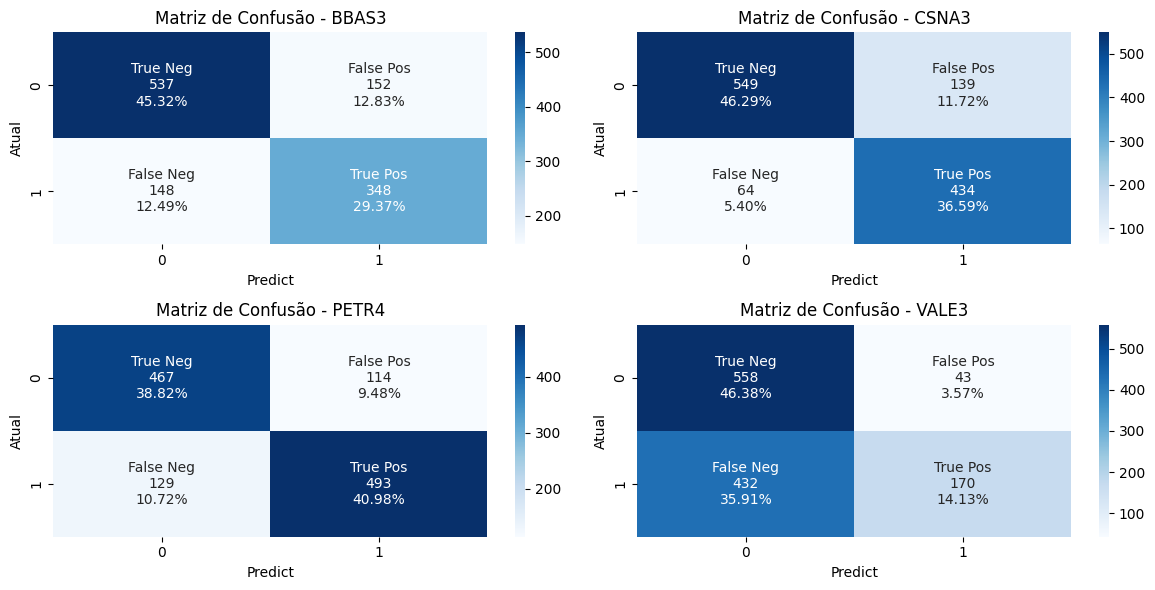

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Number of plots
num_plots = len(confusion_matrices)
cols = 2  # qtd colunas
rows = (num_plots + 1) // cols  # Numero de linhas

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
axes = axes.flatten()

# Iterate over the confusion matrices and plot each one
for i, (ticker, conf_mat) in enumerate(confusion_matrices.items()):
    # Preparing labels
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten() / np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plotting the heatmap
    sns.heatmap(conf_mat, annot=labels, fmt="", cmap='Blues', ax=axes[i])
    axes[i].set_title(f"Matriz de Confusão - {ticker}")
    axes[i].set_xlabel("Predict")
    axes[i].set_ylabel("Atual")

# Remove any unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()